In [1]:
cd MF

/home/shse/Documents/stage_cnrs/mean-field-twoNW/Najwa/MF


In [2]:
import numpy as np
import sys
#sys.path.append('mean_field_adapt')
#from transfer_functions.tf_simulation import single_experiment_2,single_experiment
from transfer_functions.load_config import load_transfer_functions,load_transfer_functions_with_ALL_params
from scipy.integrate import odeint
from single_cell_models.cell_library import get_neuron_params
from synapses_and_connectivity.syn_and_connec_library import get_connectivity_and_synapses_matrix
from transfer_functions.tf_simulation import reformat_syn_parameters
import matplotlib.pylab as plt
from transfer_functions.data import *
from graphs import *


from scipy.optimize import fsolve
from scipy.optimize import minimize
import math

In [6]:
%load_ext autoreload
%autoreload 2

In [3]:
from MF_functions_clean import *

## First, build the MF architecture and set the right parameters


In [4]:
h=0.0001
T=0.005
Ntot=10000

number_of_populations=4 # variate this paramater, first are excitators and second inihibitors 
number_of_adaptive=2

p_con=np.ones((4,4))*(0.05)#np.ones((4,4))*(0.05) ou number_of_pop*0.05
delays=np.zeros((4,4))*(0.05)
#p_con[2][2]=0.6 #inh tres connecté 
p_con[0][3]=p_con[1][2]=p_con[2][3]=p_con[3][2]=0 ## the two FS populations are not connected !
p_pois=np.ones(4)*0.05

''' Now params becomes a dictionary'''

#numb_par=28
params={}

params['diff']=[0,0,0,0] # by default nothing changes from neuron model
params['tstep']=5e-4 
params['numb_var']=number_of_populations**2+number_of_populations+number_of_adaptive#14 # total numb of var
# remove number_of_populations**2 for first order 
params['tauw']=[1,1,1e-3,1e-3] # tau_w
params['a']=[0,0,0,0] # a 0,0
params['b']=[1e-12,1e-12,0,0] # b 
#params['w']=[10e-12,10e-12,0,0]
params['El']=[-70e-3,-70e-3,-65e-3,-65e-3] # El -70e-3,-65e-3
params['total_size']=10000
params['size_subpop']=[8000,8000,2000,2000] 
params['numb_pop']=number_of_populations
params['numb_adapt']=number_of_adaptive
params['tau_e']=5e-3 # Tau_e
params['tau_i']=5e-3 # Tau_i
params['qe']=1e-9 # Qe
params['qi']=5e-9 # Qi
params['Ee']=0 # Ee
params['Ei']=-80e-3 # Ei
params['Gl']=[10e-9,10e-9,10e-9,10e-9]
params['Vthre']=[-50e-3,-50e-3,-50e-3,-50e-3]
params['Cm']=[200e-12,200e-12,200e-12,200e-12]


params['delays']=delays

params['h']=h
params['T']=T
params['mu']=mu_V_dN_dp #_FO (for firdt order)

params['ext_inp']=[0.8,0.8,0.8,0.8] #external input : Poisson law, change params 2.5 HZ
params['inp_funct']=0 # input function
params['inp_par']=0 # input parameters
params['numb_sub_exc']=2# numb_sub_exc
params['numb_sub_inh']=2# numb_sub_inh
params['p_conn']=p_con # not anymore dp, here it is plain p 
params['p_pois']=p_pois



print(params)

{'diff': [0, 0, 0, 0], 'tstep': 0.0005, 'numb_var': 22, 'tauw': [1, 1, 0.001, 0.001], 'a': [0, 0, 0, 0], 'b': [1e-12, 1e-12, 0, 0], 'El': [-0.07, -0.07, -0.065, -0.065], 'total_size': 10000, 'size_subpop': [8000, 8000, 2000, 2000], 'numb_pop': 4, 'numb_adapt': 2, 'tau_e': 0.005, 'tau_i': 0.005, 'qe': 1e-09, 'qi': 5e-09, 'Ee': 0, 'Ei': -0.08, 'Gl': [1e-08, 1e-08, 1e-08, 1e-08], 'Vthre': [-0.05, -0.05, -0.05, -0.05], 'Cm': [2e-10, 2e-10, 2e-10, 2e-10], 'delays': array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), 'h': 0.0001, 'T': 0.005, 'mu': <function mu_V_dN_dp at 0x7f5028c7fc10>, 'ext_inp': [0.8, 0.8, 0.8, 0.8], 'inp_funct': 0, 'inp_par': 0, 'numb_sub_exc': 2, 'numb_sub_inh': 2, 'p_conn': array([[0.05, 0.05, 0.05, 0.  ],
       [0.05, 0.05, 0.  , 0.05],
       [0.05, 0.05, 0.05, 0.  ],
       [0.05, 0.05, 0.  , 0.05]]), 'p_pois': array([0.05, 0.05, 0.05, 0.05])}


In [5]:
# Run the MF without adaptation a = b = 0 
#sys.path.append('../')

NTWK='CONFIG1'


NRN1='RS-cell'
NRN2='FS-cell'
#NRN3='RS-cell'
#NRN4='FS-cell'


TF_temp = load_transfer_functions_with_ALL_params(NRN1, NRN2, NTWK,params)
#TF_temp_2 = load_transfer_functions_with_ALL_params_ij(NRN1, NRN2, NTWK,par,1,3)
 # lazy to rewrite a load_TF function

TF=(TF_temp[0],TF_temp[0],TF_temp[1],TF_temp[1]) # TF defined as a tuple

params['TF']=TF


In [13]:
print(params['numb_var'])

22


### Integration of the MF equations with delays

##### Straight to second order !

In [12]:
#np.random.seed(10)
#x0=np.random.rand(7)*1e-5

x0=np.ones(params['numb_var'])*1e-5 
x0[0]=0.6 #ve1 exp 
x0[1]=0.6 #ve2 exp
x0[2]=7.0 #vi1 exp 
x0[3]=7.0 #vi2 exp
x0[20]=x0[0]*60e-12 #x0[0]*60e-12 ici point fixe pour la stabilité
x0[21]=x0[1]*60e-12 #w exp

print(x0)
time=0
t_trace=[]
x_trace_RS=[]
TF_trace_RS=[]


x_trace_RS.append(x0.copy())
#x_trace_RS.append(x0.copy())

##################### INITIATE THE PAST COORDINANTES ##########################

delay_matrix=np.matrix(delays)
max_delay=delay_matrix.max()

#### Associated number of time steps ####

steps=int(max_delay/params['tstep'])

for i in range(steps):x_trace_RS.append(x0.copy())
    
##################################################################################

print(x0)
time=0
    
for i in np.arange(0,5,params['tstep']):
    params['x_hist']=np.transpose(x_trace_RS)
    TF_inst=Euler_method_General(x0,params,time,MeanField_dN_dp_delay)
    if (i%0.5==0):print('i = ', i, '\n')
    time+=params['tstep']
    t_trace.append(time)
    x_trace_RS.append(x0.copy())
    TF_trace_RS.append(TF_inst.copy())
    

[6.0e-01 6.0e-01 7.0e+00 7.0e+00 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05
 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05
 1.0e-05 1.0e-05 3.6e-11 3.6e-11]
[6.0e-01 6.0e-01 7.0e+00 7.0e+00 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05
 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05 1.0e-05
 1.0e-05 1.0e-05 3.6e-11 3.6e-11]
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

i =  2.0 

i =  2.5 

i =  3.0 

i =  3.5 

i =  4.0 

i =  4.5 



In [13]:
final_state=x_trace_RS[-1]
print(final_state)
#intégrer la dérivé , ici valeurs de nu_out 
#trouver pts fixes des, donné les freq vers les quelles elles 

[1.00000000e-08 1.00000000e-08 1.00000000e-08 1.00000000e-08
 1.25000000e-10 2.18952885e-47 2.18952885e-47 2.18952885e-47
 2.18952885e-47 1.25000000e-10 2.18952885e-47 2.18952885e-47
 2.18952885e-47 2.18952885e-47 5.00000000e-10 2.18952885e-47
 2.18952885e-47 2.18952885e-47 2.18952885e-47 5.00000000e-10
 2.42283273e-13 2.42283273e-13]


In [13]:
x_transp=np.transpose(x_trace_RS)
TF_transp=np.transpose(TF_trace_RS)
ve1=x_transp[0]#[1000:] # remove first 10000 elements
ve2=x_transp[1]#[1000:]
vi1=x_transp[2]#[1000:]
vi2=x_transp[3]#[1000:]
#ce1i1=np.sqrt(x_transp[5])#[1000:]
#cii=np.sqrt(x_transp[5])#[1000:]
w1=x_transp[20]
w2=x_transp[21]
#cv_i=cee/ve
#cv_e=cii/vi
#print(cee[:1000],cii[:1000])

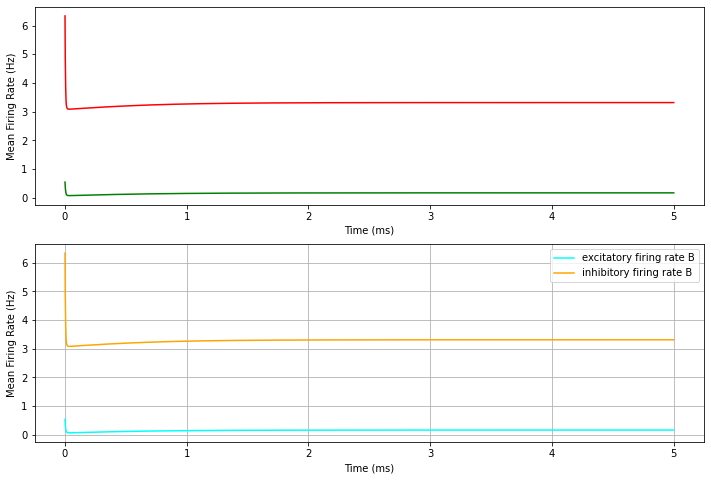

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(t_trace, ve1[1:], color="green", label="excitatory firing rate A")
axs[0].plot(t_trace, vi1[1:], color="red", label="inhibitory firing rate A")
axs[1].plot(t_trace, ve1[1:], color="cyan", label="excitatory firing rate B")
axs[1].plot(t_trace, vi2[1:], color="orange", label="inhibitory firing rate B")
#axs[0].plot(TimBinned/1000,  popRateG2, color="green",ls="--", label="excitatory firing rate")
#plt.plot(TimBinned/1000, popRateG1, color="red",ls="--", label="inhibitory firing rate")

#plt.grid(True)
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Mean Firing Rate (Hz)")
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylabel("Mean Firing Rate (Hz)")

plt.legend()
plt.grid(True)
#plt.title("Mean-Field Dynamics")
#plt.ylim(-20,20)
#plt.xlim(0,0.1)
plt.show()

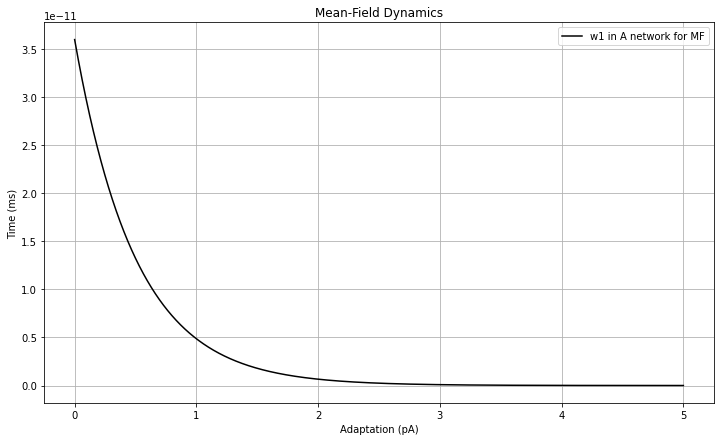

In [15]:
plt.figure(figsize=(12, 7))
plt.plot(t_trace,w1[1:],color="black",label="w1 in A network for MF")
#plt.plot(t_trace,w2,color="black",label="w2 in A network for MF")
#for a in range(len(LVG1)):
    #plt.plot(Lt2G2/400,LwG2[a],color="blue",ls='--',label="w1 in A for Adex")
#for a in range(len(LVG3)):
    #plt.plot(Lt2G4/400,LwG4[a],color="black",ls='--',label="w2 in A for Adex")

plt.xlabel("Adaptation (pA)")
plt.grid(True)
plt.ylabel("Time (ms)")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(-20,20)
#plt.xlim(0,0.1)
plt.show()

In [29]:
delays=np.zeros((4,4))
#delays[0][3]=delays[1][2]=0.001 #proche  #delays[0][1]=delays[1][0]
#delays[0][1]=delays[0][3]=delays[1][0]=delays[1][2]=0.005 #delai colonne distantes entre exc-inh et exc-exc colonnes diff
print(delays)

ValueError: setting an array element with a sequence.

In [29]:
for delays in np.linspace(0,5e-3,6):
	for qe in np.linspace(0,5e-9,6):
		params['delays'][0][1]=delays
		params['delays'][1][0]=delays
		params['delays'][2][1]=delays
		params['delays'][3][0]=delays
		params['qe']=qe
		delay_matrix=np.matrix(delays)
		max_delay=delay_matrix.max()


In [33]:
params['delays']

array([[0., 2., 0., 0.],
       [2., 0., 0., 0.],
       [0., 2., 0., 0.],
       [2., 0., 0., 0.]])

In [ ]:
for delay in np.linspace(0,5e-3,6):
	for qe in np.linspace(0,5e-9,6):
		print('#############################################')
		print(' \n \n sim1 : delay = ', delay,' qe = ',qe,' \n \n')
		print('#############################################')

		np.random.seed(10)
		#x0=np.random.rand(7)*1e-5
		#x0=np.ones(7)*1e-5
		#x0=np.random.rand(7)*1e-5
		#x0=np.ones(params['numb_var'])*1e-5

		#for i in range(n_a):
		#    x0[n_p+i]=x0[i]*params['b'][i]

		#x0=final_state.copy()
		x0=np.ones(params['numb_var'])*1e-5 
		x0[0]=0.6 #ve1 exp 
		x0[1]=0.6 #ve2 exp
		x0[2]=7.0 #vi1 exp 
		x0[3]=7.0 #vi2 exp
		x0[20]=x0[0]*60e-12 #x0[0]*60e-12 ici point fixe pour la stabilité
		x0[21]=x0[1]*60e-12 #w exp

		#print(x0)
		time=0
		t_trace=[]
		x_trace_RS=[]
		TF_trace_RS=[]

		x_trace_RS.append(x0.copy())

		''' DEFINE THE INPUT FUNCTION '''
		#steps=int(delay/params['tstep'])

		#for i in range(steps):x_trace_RS.append(x0.copy())
		params['qe']=qe
		params['delays'][0][1]=delay
		params['delays'][1][0]=delay
		params['delays'][2][1]=delay
		params['delays'][3][0]=delay
        #delays[0][1]=delays[3][0]=delays[1][0]=delays[2][1]=0.005
		
		###########################################
		###########################################
		

##################### INITIATE THE PAST COORDINANTES ##########################
		#delay_matrix=np.matrix(delays)
		#max_delay=delay_matrix.max()

#### Associated number of time steps ####

		#steps=int(max_delay/params['tstep'])

		#for i in range(steps):x_trace_RS.append(x0.copy())
    
##################################################################################

		#print(x0)
		#print(params['delays'])
		#time=0
        
		for i in np.arange(0,5,params['tstep']):
			params['x_hist']=np.transpose(x_trace_RS)
			TF_inst=Euler_method_General(x0,params,time,MeanField_dN_dp_delay)
			if (i%0.5==0):print('i = ', i, '\n')
			time+=params['tstep']
			t_trace.append(time)
			x_trace_RS.append(x0.copy())
			TF_trace_RS.append(TF_inst.copy())
    

#############################################
 
 
 sim1 : delay =  0.0  qe =  0.0  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

i =  2.0 

i =  2.5 

i =  3.0 

i =  3.5 

i =  4.0 

i =  4.5 

#############################################
 
 
 sim1 : delay =  0.0  qe =  1e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

i =  2.0 

i =  2.5 

i =  3.0 

i =  3.5 

i =  4.0 

i =  4.5 

#############################################
 
 
 sim1 : delay =  0.0  qe =  2e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

i =  2.0 

i =  2.5 

i =  3.0 

i =  3.5 

i =  4.0 

i =  4.5 

#############################################
 
 
 sim1 : delay =  0.0  qe =  3.0000000000000004e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

i =  2.0 

i =  2.5 

i =  3.0 

i =  3.5 

i =  4.0 

i =  4.5 

#####

In [22]:
final_state=x_trace_RS1[-1]
print(final_state)

[ 4.90354898e-02  4.90354898e-02  1.83213601e+00  6.96156074e+00
  4.32380489e-04  3.00449580e-04 -6.79913140e-03  4.26293843e-02
  3.00449580e-04  4.30977262e-04 -6.95141979e-03  4.28021810e-02
 -6.79913140e-03 -6.95141979e-03  5.53789793e-01  7.74495000e-01
  4.26293843e-02  4.28021810e-02  7.74495000e-01  1.05866022e+01
  7.34627227e-20  7.34627227e-20]


In [32]:
x_transp=np.transpose(x_trace_RS1)
TF_transp=np.transpose(TF_trace_RS1)
ve1=x_transp[0]#[1000:] # remove first 10000 elements
ve2_1_5=x_transp[1]#[1000:]
vi1=x_transp[2]#[1000:]
vi2=x_transp[3]#[1000:]
#ce1i1=np.sqrt(x_transp[5])#[1000:]
#cii=np.sqrt(x_transp[5])#[1000:]
w1=x_transp[20]
w2=x_transp[21]

In [33]:
plt.imshow(ve1[steps+1:],cmap=plt.cm.jet,interpolation='nearest')

[0.66466646 0.66466646 0.66466646 ... 0.04498715 0.04879626 0.04903549]


In [ ]:
x_transp=np.transpose(x_trace_RS2)
ve1_2_5=x_transp[0]#[1000:] # remove first 10000 elements
ve2_2_5=x_transp[1]#[1000:]

In [ ]:
x_transp=np.transpose(x_trace_RS3)
ve1_3_5=x_transp[0]#[1000:] # remove first 10000 elements
ve2_3_5=x_transp[1]#[1000:]

In [ ]:
x_transp=np.transpose(x_trace_RS4)
ve1_4_5=x_transp[0]#[1000:] # remove first 10000 elements
ve2_4_5=x_transp[1]#[1000:]

In [ ]:
x_transp=np.transpose(x_trace_RS5)
ve1_5_5=x_transp[0]#[1000:] # remove first 10000 elements
ve2_5_5=x_transp[1]#[1000:]

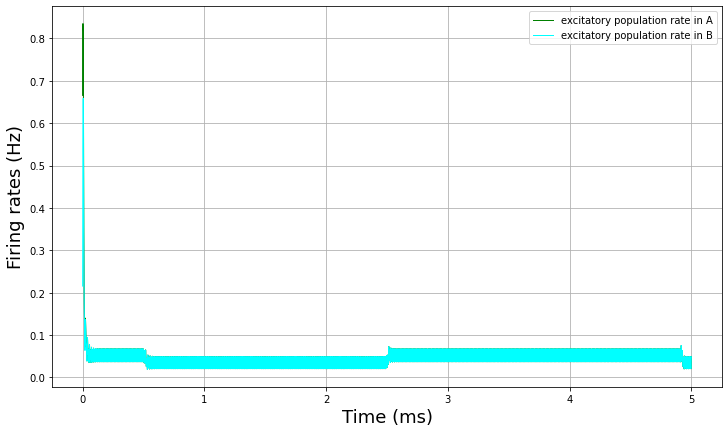

In [27]:
fig,ax=plt.subplots(figsize=(12, 7))

ax.plot(t_trace1,ve1_1[steps+1:],color="green",lw="1",label="excitatory population rate in A")
#ax.plot(t_trace,vi1[steps+1:],color="red",lw="1",label="inhibitory population rate in A")
ax.plot(t_trace1,ve2_1[steps+1:],color="cyan",lw="1",label="excitatory population rate in B")
#ax.plot(t_trace,vi2[steps+1:],color="orange",lw="1",label="inhibitory population rate in B")
#ax.plot(t[100:]*1000, state_2[100:, 0], color="green",lw="2", ls="--")
#ax.plot(t[100:]*1000, state_2[100:, 1], color="red", lw="2",ls="--")

#ax.plot(t, state_2[:, 2], color="blue", label="excitory cee")
#ax.plot(t, state_2[:, 3], color="purple", label="inhibitory cii")
#ax.plot(t, state_2[:, 4], color="yellow", label="cei")
#ax.plot(t, state_2[:, 5], color="orange", label="cei")
#ax.plot(t,test_input, color="black", linestyle=":", label="forcing")



ax.set_xlabel("Time (ms)",fontsize=18)
ax.grid(True)
ax.set_ylabel("Firing rates (Hz)",fontsize=18)
ax.legend()
#ax.title("Mean-Field Dynamics")
#ax.set_xlim(2,3)
#ax.show()

# Perturbation

In [ ]:
AmpStim1=0.5
#Binp=2
def heaviside(x):
    return 0.5 * (1 + np.sign(x))


def input_rate(t, t1_exc, tau1_exc, tau2_exc, ampl_exc):
    # t1_exc=10. # time of the maximum of external stimulation
    # tau1_exc=20. # first time constant of perturbation = rising time
    # tau2_exc=50. # decaying time
    # ampl_exc=20. # amplitude of excitation
    inp = ampl_exc * (np.exp(-(t - t1_exc) ** 2 / (2. * tau1_exc ** 2)) * heaviside(-(t - t1_exc)) + \
                      np.exp(-(t - t1_exc) ** 2 / (2. * tau2_exc ** 2)) * heaviside(t - t1_exc))
    return inp

'''
input_rate=params['inp_funct']

if (input_rate != 0): input_func=input_rate(t, *params['inp_par'])
else : input_func=0

ji, 1000., 10., 400., AmpStim1))
'''

params['inp_funct']=input_rate # input function
params['inp_par']=[1., 0.02, 0.02, AmpStim1] # input parameters

In [ ]:
np.random.seed(10)
x0=final_state.copy()
#x0[0]+=0.5
print(x0)
time=0
t_trace=[]]
x_trace_RS=[]
TF_trace_RS=[]

x_trace_RS.append(x0.copy())
#x_trace_RS.append(x0.copy())

##################### INITIATE THE PAST COORDINANTES ##########################

delay_matrix=np.matrix(delays)
max_delay=delay_matrix.max()
print('Max delay = ', max_delay)
#### Associated number of time steps ####

steps=int(max_delay/params['tstep'])

for i in range(steps):x_trace_RS.append(x0.copy())
    
##################################################################################

print(x0)
time=0
    
for i in np.arange(0,5,params['tstep']):
    params['x_hist']=np.transpose(x_trace_RS)
    TF_inst=Euler_method_General(x0,params,time,MeanField_dN_dp_delay)
    if (i%0.5==0):print('i = ', i, '\n')
    time+=params['tstep']
    t_trace.append(time)
    x_trace_RS.append(x0.copy())
    TF_trace_RS.append(TF_inst.copy())

In [ ]:
final_state=x_trace_RS[-1]
print(final_state)

In [ ]:
x_transp=np.transpose(x_trace_RS)
TF_transp=np.transpose(TF_trace_RS)
ve1=x_transp[0]#[1000:] # remove first 10000 elements
ve2=x_transp[1]#[1000:]
vi1=x_transp[2]#[1000:]
vi2=x_transp[3]#[1000:]
#ce1i1=np.sqrt(x_transp[5])#[1000:]
#cii=np.sqrt(x_transp[5])#[1000:]
w1=x_transp[20]
w2=x_transp[21]

In [ ]:
fig,ax=plt.subplots(figsize=(12, 7))

ax.plot(t_trace,ve[steps+1:],color="green",lw="1",label="excitatory population rate")
ax.plot(t_trace,vi[steps+1:],color="red",lw="1",label="inhibitory population rate")
#ax.plot(t[100:]*1000, state_2[100:, 0], color="green",lw="2", ls="--")
#ax.plot(t[100:]*1000, state_2[100:, 1], color="red", lw="2",ls="--")

#ax.plot(t, state_2[:, 2], color="blue", label="excitory cee")
#ax.plot(t, state_2[:, 3], color="purple", label="inhibitory cii")
#ax.plot(t, state_2[:, 4], color="yellow", label="cei")
#ax.plot(t, state_2[:, 5], color="orange", label="cei")
#ax.plot(t,test_input, color="black", linestyle=":", label="forcing")



ax.set_xlabel("Time (ms)",fontsize=18)
ax.grid(True)
ax.set_ylabel("Firing rates (Hz)",fontsize=18)
ax.legend()
#ax.title("Mean-Field Dynamics")
ax.set_xlim(2,3)
#ax.show()

### Load network activity to compare with MF

--##Start simulation##--
--##End simulation##--
0.312516891860957
0.3298529203966033
0.30925907966015254
0.3227704565111241


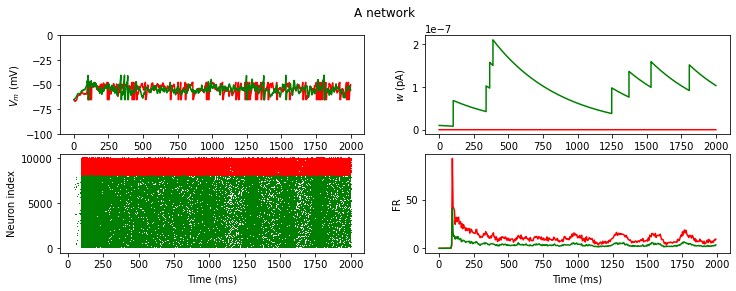

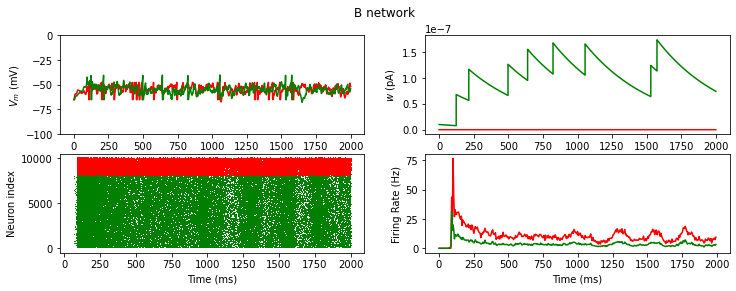

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
import scipy.fftpack

def bin_array(array, BIN, time_array):
    N0 = int(BIN/(time_array[1]-time_array[0]))
    N1 = int((time_array[-1]-time_array[0])/BIN)
    return array[:N0*N1].reshape((N1,N0)).mean(axis=1)


start_scope()
DT=0.1 #fenetre de temps à modifier 
defaultclock.dt = DT*ms
N1 = 2000#2000
N2 = 8000#8000

TotTime=2000
duration = TotTime*ms



eqs='''
dv/dt = (-GsynE*(v-Ee)-GsynI*(v-Ei)-gl*(v-El)+ gl*Dt*exp((v-Vt)/Dt)-w + Is)/Cm : volt (unless refractory)
dw/dt = (a*(v-El)-w)/tau_w:ampere
dGsynI/dt = -GsynI/Tsyn : siemens
dGsynE/dt = -GsynE/Tsyn : siemens
Is:ampere
Cm:farad
gl:siemens
El:volt
a:siemens
tau_w:second
Dt:volt
Vt:volt
Ee:volt
Ei:volt
Tsyn:second
'''

# Populations----------------------------------------------------------------------------------

############################ First Adex FS-RS population 1-2 ####################################
# Population 1 - FS
b1 = 0.0*pA # no adaptation for FS 
G1 = NeuronGroup(N1, eqs, threshold='v > -47.5*mV', reset='v = -65*mV', refractory='5*ms', method='heun')
#
#init:
G1.v = -65*mV
G1.w = 0.0*pA
G1.GsynI=0.0*nS
G1.GsynE=0.0*nS
#parameters
G1.Cm = 200.*pF
G1.gl = 10.*nS
G1.El = -70.*mV
G1.Vt = -48.*mV
G1.Dt = 0.5*mV
G1.tau_w = 1.0*ms
G1.a = 0.0*nS
G1.Is = 0.0 #[0.0 for i in range(N1)]*nA

G1.Ee=0.*mV
G1.Ei=-80.*mV
G1.Tsyn=5.*ms

# Population 2 - RS
b2 = 60.*pA #adaptation for RS (slow adaptation or spike frequency adapatation)
G2 = NeuronGroup(N2, eqs, threshold='v > -40.0*mV', reset='v = -65*mV; w += b2', refractory='5*ms',  method='heun')
G2.v = -65.*mV
G2.w = 10.0*pA
G2.GsynI=0.0*nS
G2.GsynE=0.0*nS
G2.Cm = 200.*pF
G2.gl = 10.*nS
G2.El = -65.*mV
G2.Vt = -50.*mV
G2.Dt = 2.*mV
G2.tau_w = 500.*ms
G2.a = 0.*nS
G2.Is = 0.0*nA #2.50*nA #[0.0 for i in range(N2)]*nA
#G2.Is[0]=0.*nA

G2.Ee=0.*mV
G2.Ei=-80.*mV
G2.Tsyn=5.*ms


# external drive-------------------------------------------------------------------------- Poisson distribution because of complex pattern of firing rate population spikes (fundamental hypothesis of the AdEx and because of chaos theory).

P_edA=PoissonGroup(8000, .8*Hz) #see what happens with external input on A network, compare witgh same input on B at the same time 

# connections-----------------------------------------------------------------------------

Qi=5.0*nS
Qe=1.*nS

prbC= 0.05 #0.05 => 5% of connectivity probability to explain (admit now, in research), "threshold to observe realisftic neural dynamics"
prbC2=0.05
S_12 = Synapses(G1, G2, on_pre='GsynI_post+=Qi') #'v_post -= 1.*mV'
S_12.connect('i!=j', p=prbC2)

S_11 = Synapses(G1, G1, on_pre='GsynI_post+=Qi')
S_11.connect('i!=j',p=prbC2)

S_21 = Synapses(G2, G1, on_pre='GsynE_post+=Qe')
S_21.connect('i!=j',p=prbC)

S_22 = Synapses(G2, G2, on_pre='GsynE_post+=Qe')
S_22.connect('i!=j', p=prbC)

#Synaptic Connections with external input and the inhibitors/excitators cells in B network 
#Si_inex2=[a for a in S_ed_inB.i] # inibitors-external input from neuron i
#Sj_inex2=[a for a in S_ed_inB.j] # inibitors-external input from neuron j
#Si_exex2=[a for a in S_ed_exB.i] # excitators-external input from neuron i
#Sj_exex2=[a for a in S_ed_exB.j] # excitators-external input from neuron j


############## #synapses from external drive to both populations of A network:
S_ed_inA = Synapses(P_edA, G1, on_pre='GsynE_post+=Qe') # Synapses receives the extrernal input in the A network, incremental quantal Qe because the external input is excitator 
#S_ed_inA.connect(i=Si_inex2, j=Sj_inex2) # synaptic connections of inibitors-external input of inibitors cells synapses connections
S_ed_inA.connect(p=prbC)

S_ed_exA = Synapses(P_edA, G2, on_pre='GsynE_post+=Qe')
S_ed_exA.connect(p=prbC)
#S_ed_exA.connect(i=Si_exex2, j=Sj_exex2) # synaptic connections of excitators-external input of inibitors cells synapses connections



Vtt=1 #Vtt => mean threshold of the membran potential of each adex

M1G1 = SpikeMonitor(G1)
M2G1 = StateMonitor(G1, 'v', record=range(Vtt))
M3G1 = StateMonitor(G1, 'w', record=range(Vtt))
M4G1 = StateMonitor(G1, 'GsynE', record=range(Vtt)) #monitoring of the synchronous conductance of the FS in G1
M5G1 = StateMonitor(G1, 'GsynI', record=range(Vtt)) #monitoring of the synchronous conductance of the RS in G1
FRG1 = PopulationRateMonitor(G1)

M1G2 = SpikeMonitor(G2)
M2G2 = StateMonitor(G2, 'v', record=range(Vtt))
M3G2 = StateMonitor(G2, 'w', record=range(Vtt))
M4G2 = StateMonitor(G2, 'GsynE', record=range(Vtt))
M5G2 = StateMonitor(G2, 'GsynI', record=range(Vtt))
FRG2 = PopulationRateMonitor(G2)

######################################################## Second ADEX FS-RS ##########################################################
##################################################################################################################

# Population 3 - FS
b3 = 0.0*pA
G3 = NeuronGroup(N1, eqs, threshold='v > -47.5*mV', reset='v = -65*mV', refractory='5*ms', method='heun')
#init:
G3.v = -65*mV
G3.w = 0.0*pA
G3.GsynI=0.0*nS
G3.GsynE=0.0*nS
#parameters
G3.Cm = 200.*pF
G3.gl = 10.*nS
G3.El = -70.*mV
G3.Vt = -48.*mV
G3.Dt = 0.5*mV
G3.tau_w = 1.0*ms
G3.a = 0.0*nS
G3.Is = 0.0 #[0.0 for i in range(N1)]*nA

G3.Ee=0.*mV
G3.Ei=-80.*mV
G3.Tsyn=5.*ms

# Population 4 - RS
b4 = 60.*pA
G4 = NeuronGroup(N2, eqs, threshold='v > -40.0*mV', reset='v = -65*mV; w += b4', refractory='5*ms',  method='heun')
G4.v = -65.*mV
G4.w = 10.0*pA
G4.GsynI=0.0*nS
G4.GsynE=0.0*nS
G4.Cm = 200.*pF
G4.gl = 10.*nS
G4.El = -65.*mV
G4.Vt = -50.*mV
G4.Dt = 2.*mV
G4.tau_w = 500.*ms
G4.a = 0.*nS
G4.Is = 0.0*nA #2.50*nA #[0.0 for i in range(N2)]*nA
#G2.Is[0]=0.*nA

G4.Ee=0.*mV
G4.Ei=-80.*mV
G4.Tsyn=5.*ms

# external drive--------------------------------------------------------------------------

P_edB=PoissonGroup(8000, .8*Hz) #here we have only the external input in B network 

# connections-----------------------------------------------------------------------------

Qi=5.0*nS
Qe=1.0*nS

"""
#a mettre en commentaire pour test (structure pareille)
Si34=[a for a in S_12.i]
Sj34=[a for a in S_12.j]
Si33=[a for a in S_11.i]
Sj33=[a for a in S_11.j]
Si43=[a for a in S_21.i]
Sj43=[a for a in S_21.j]
Si44=[a for a in S_22.i]
Sj44=[a for a in S_22.j]
"""

prbC= 0.05 #0.05
prbC2=0.05
S_34 = Synapses(G3, G4, on_pre='GsynI_post+=Qi') #'v_post -= 1.*mV')
S_34.connect('i!=j', p=prbC)

S_33 = Synapses(G3, G3, on_pre='GsynI_post+=Qi')
S_33.connect('i!=j', p=prbC)

S_43 = Synapses(G4, G3, on_pre='GsynE_post+=Qe')
S_43.connect('i!=j', p=prbC)

S_44 = Synapses(G4, G4, on_pre='GsynE_post+=Qe')
S_44.connect('i!=j', p=prbC)

'''
#Synaptic Connections with external input and the inhibitors/excitators cells in A network 
Si_inex=[a for a in S_ed_inA.i] # inibitors-external input from neuron i
Sj_inex=[a for a in S_ed_inA.j] # inibitors-external input from neuron j
Si_exex=[a for a in S_ed_exA.i] # excitators-external input from neuron i
Sj_exex=[a for a in S_ed_exA.j] # excitators-external input from neuron j
'''


####### display Synaptic Connections with external input and the inhibitors/excitators cells in B network 
S_ed_inB = Synapses(P_edB, G3, on_pre='GsynE_post+=Qe')
#S_ed_inB.connect(i=Si_inex, j=Sj_inex) # synaptic connections of inibitors-external input of inibitors cells synapses connections in B
S_ed_inB.connect(p=prbC)


S_ed_exB = Synapses(P_edB, G4, on_pre='GsynE_post+=Qe')
#S_ed_exB.connect(i=Si_exex, j=Sj_exex) # synaptic connections of excitators-external input of excitatory cells synapses connections in B
S_ed_exB.connect(p=prbC)


Vtt=1

M1G3 = SpikeMonitor(G3)
M2G3 = StateMonitor(G3, 'v', record=range(Vtt))
M3G3 = StateMonitor(G3, 'w', record=range(Vtt))
M4G3 = StateMonitor(G3, 'GsynE', record=range(Vtt))
M5G3 = StateMonitor(G3, 'GsynI', record=range(Vtt))
FRG3 = PopulationRateMonitor(G3)

M1G4 = SpikeMonitor(G4)
M2G4 = StateMonitor(G4, 'v', record=range(Vtt))
M3G4 = StateMonitor(G4, 'w', record=range(Vtt))
M4G4 = StateMonitor(G4, 'GsynE', record=range(Vtt))
M5G4 = StateMonitor(G4, 'GsynI', record=range(Vtt))
FRG4 = PopulationRateMonitor(G4)


##################################################################################################################
##################################################################################################################


prbCBA=0.05

#Synaptic Connection from B (G3-G4) A (G1-G2) to  synapses 
#S_ABii = Synapses(G3, G1, on_pre='GsynI_post+=Qi')
#S_ABii.connect('i!=j',p=prbCBA)

#S_ABie = Synapses(G3, G2, on_pre='GsynI_post+=Qi')
#S_ABie.connect('i!=j',p=prbCBA)



S_ABei = Synapses(G4, G1, on_pre='GsynE_post+=Qe',delay=5*ms)
S_ABei.connect('i!=j',p=prbCBA)

S_ABee = Synapses(G4, G2, on_pre='GsynE_post+=Qe',delay=5*ms)
S_ABee.connect('i!=j',p=prbCBA)



##################################################################################################################
##################################################################################################################


#Synaptic Connection from A (G1-G2) to  B (G3-G4) synapses 
prbCAB=0.05
#
#S_BAii = Synapses(G1, G3, on_pre='GsynI_post+=Qi')
#S_BAii.connect('i!=j',p=prbCAB)
#
#S_BAie = Synapses(G1, G4, on_pre='GsynI_post+=Qi')
#S_BAie.connect('i!=j',p=prbCAB)
#
#
#
S_BAei = Synapses(G2, G3, on_pre='GsynE_post+=Qe',delay=5*ms)
S_BAei.connect('i!=j',p=prbCAB)
#
S_BAee = Synapses(G2, G4, on_pre='GsynE_post+=Qe',delay=5*ms)
S_BAee.connect('i!=j',p=prbCAB)



##################################################################################################################
##################################################################################################################

print('--##Start simulation##--')
run(duration)
print('--##End simulation##--')


# Plots -------------------------------------------------------------------------------


RasG1 = np.array([M1G1.t/ms, [i+N2 for i in M1G1.i]])
RasG2 = np.array([M1G2.t/ms, M1G2.i])


LVG1=[]
LwG1=[]
LVG2=[]
LwG2=[]

LgseG1=[]
LgsiG1=[]
LgseG2=[]
LgsiG2=[]

for a in range(Vtt):
    LVG1.append(array(M2G1[a].v/mV))
    LwG1.append(array(M3G1[a].w/mamp))
    LVG2.append(array(M2G2[a].v/mV))
    LwG2.append(array(M3G2[a].w/mamp))
    LgseG1.append(array(M4G1[a].GsynE/nS))
    LgsiG1.append(array(M5G1[a].GsynI/nS))
    LgseG2.append(array(M4G2[a].GsynE/nS))
    LgsiG2.append(array(M5G2[a].GsynI/nS))


BIN=5
time_array = np.arange(int(TotTime/DT))*DT



LfrG2=np.array(FRG2.rate/Hz)
TimBinned,popRateG2=bin_array(time_array, BIN, time_array),bin_array(LfrG2, BIN, time_array)

LfrG1=np.array(FRG1.rate/Hz)
TimBinned,popRateG1=bin_array(time_array, BIN, time_array),bin_array(LfrG1, BIN, time_array)



Lt1G1=array(M2G1.t/ms)
Lt2G1=array(M3G1.t/ms)
Lt1G2=array(M2G2.t/ms)
Lt2G2=array(M3G2.t/ms)



fig=plt.figure(figsize=(12,4))
fig.suptitle('A network')
ax1=fig.add_subplot(221)
ax2=fig.add_subplot(222)

for a in range(len(LVG1)):
    ax1.plot(Lt1G1, LVG1[a],'r')
    ax2.plot(Lt2G1, LwG1[a],'r')
    ax1.plot(Lt1G2, LVG2[a],'g')
    ax2.plot(Lt2G2, LwG2[a],'g')


ax1.set_ylim([-100, 0])
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('$V_m$ (mV)') # v : membrane voltage 

ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('$w$ (pA)')# synapses weights 

ax3=fig.add_subplot(223)
ax3.plot(RasG1[0], RasG1[1], ',r')
ax3.plot(RasG2[0], RasG2[1], ',g')

ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Neuron index')
ax4=fig.add_subplot(224)
ax4.plot(TimBinned,popRateG1, 'r')
ax4.plot(TimBinned,popRateG2, 'g')

ax4.set_xlabel('Time (ms)')
ax4.set_ylabel('FR')




#######################################################
RasG3 = np.array([M1G3.t/ms, [i+N2 for i in M1G3.i]])
RasG4 = np.array([M1G4.t/ms, M1G4.i])


LVG3=[]
LwG3=[]
LVG4=[]
LwG4=[]

LgseG3=[]
LgsiG3=[]
LgseG4=[]
LgsiG4=[]

for a in range(Vtt):
    LVG3.append(array(M2G3[a].v/mV))
    LwG3.append(array(M3G3[a].w/mamp))
    LVG4.append(array(M2G4[a].v/mV))
    LwG4.append(array(M3G4[a].w/mamp))
    LgseG3.append(array(M4G3[a].GsynE/nS))
    LgsiG3.append(array(M5G3[a].GsynI/nS))
    LgseG4.append(array(M4G4[a].GsynE/nS))
    LgsiG4.append(array(M5G4[a].GsynI/nS))


BIN=5
time_array = np.arange(int(TotTime/DT))*DT



LfrG4=np.array(FRG4.rate/Hz)
TimBinned,popRateG4=bin_array(time_array, BIN, time_array),bin_array(LfrG4, BIN, time_array)

LfrG3=np.array(FRG3.rate/Hz)
TimBinned,popRateG3=bin_array(time_array, BIN, time_array),bin_array(LfrG3, BIN, time_array)



Lt1G3=array(M2G3.t/ms)
Lt2G3=array(M3G3.t/ms)
Lt1G4=array(M2G4.t/ms)
Lt2G4=array(M3G4.t/ms)



figB=plt.figure(figsize=(12,4))
figB.suptitle('B network')
ax1B=figB.add_subplot(221)
ax2B=figB.add_subplot(222)

for a in range(len(LVG3)):
    ax1B.plot(Lt1G3, LVG3[a],'r')
    ax2B.plot(Lt2G3, LwG3[a],'r')
    ax1B.plot(Lt1G4, LVG4[a],'g')
    ax2B.plot(Lt2G4, LwG4[a],'g')


ax1B.set_ylim([-100, 0])
ax1B.set_xlabel('Time (ms)')
ax1B.set_ylabel('$V_m$ (mV)') # v : membrane voltage 

ax2B.set_xlabel('Time (ms)')
ax2B.set_ylabel('$w$ (pA)')# synapses weights 

ax3B=figB.add_subplot(223)
ax3B.plot(RasG3[0], RasG3[1], ',r')
ax3B.plot(RasG4[0], RasG4[1], ',g')

ax3B.set_xlabel('Time (ms)')
ax3B.set_ylabel('Neuron index')
ax4B=figB.add_subplot(224)
ax4B.plot(TimBinned,popRateG3, 'r')
ax4B.plot(TimBinned,popRateG4, 'g')

ax4B.set_xlabel('Time (ms)')
ax4B.set_ylabel('Firing Rate (Hz)')

print(numpy.std(popRateG1[100:])/np.mean(popRateG1[100:]))
print(numpy.std(popRateG2[100:])/np.mean(popRateG2[100:]))
print(numpy.std(popRateG3[100:])/np.mean(popRateG3[100:]))
print(numpy.std(popRateG4[100:])/np.mean(popRateG4[100:]))

plt.show()

In [74]:
arr=[popRateG1,popRateG2,LwG2,LVG1,LVG2,LfrG1,LfrG2,TimBinned,time_array]
np.save('4pop_data_sim1.npy', arr)
print("Your array has been saved to 4pop_data_sim1.npy")

WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
 [py.warnings]


Your array has been saved to 2pop_data.npy


In [76]:
data = np.load('4pop_data_sim1.npy',allow_pickle=True)
print("The data is:")
print(data)

The data is:
[array([0. , 5.2, 8.2, ..., 7.5, 5.7, 6.7])
 array([0.   , 0.025, 0.225, ..., 0.1  , 0.025, 0.025])
 list([array([0.00000000e+00, 2.66666667e-12, 5.31982370e-12, ...,
       4.90407489e-08, 4.90411934e-08, 4.90416527e-08])])
 list([array([-65.        , -65.        , -65.        , ..., -55.85157939,
       -55.70299375, -55.56038117])])
 list([array([-65.        , -65.04999447, -65.09974044, ..., -61.07262722,
       -61.01745606, -60.96622138])])
 array([0., 0., 0., ..., 0., 5., 0.]) array([0., 0., 0., ..., 0., 0., 0.])
 array([2.45000e+00, 7.45000e+00, 1.24500e+01, ..., 9.98245e+03,
       9.98745e+03, 9.99245e+03])
 array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 9.9997e+03, 9.9998e+03,
       9.9999e+03])]


In [77]:
popRateG1=data[0]
popRateG2=data[1]
LwG2=data[2]
LVG1=data[3]
LVG2=data[4]
LfrG1=data[5]
LfrG2=data[6]
TimBinned=data[7]
time_array=data[8]

In [ ]:
trains = M1G1.spike_trains()
isi_mu = full(num_tau, nan)*second
isi_std = full(num_tau, nan)*second
for idx in range(num_tau):
    train = diff(trains[idx])
    if len(train)>1:
        isi_mu[idx] = mean(train)
        isi_std[idx] = std(train)
errorbar(tau_range/ms, isi_mu/ms, yerr=isi_std/ms)
xlabel(r'$\tau$ (ms)')
ylabel('Interspike interval (ms)');

In [8]:
M1G2_list=list(M1G2.i)
M1G4_list=list(M1G4.i)

In [19]:
exc_sp=(M1G2.i)+(M1G4.i[0:60328])
exec_time=(M1G2.t/ms)+(M1G4.t/ms)[0:60328]

No handles with labels found to put in legend.


[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

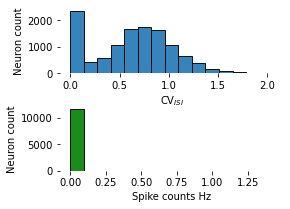

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(4, 3))
sp = exc_sp
times = exec_time
nNeurons = max(sp) + 1
nSpikes = len(sp)

spiketimes = {}
for n in range(nNeurons):
    ts = list(times[(np.where(sp == n))])
    #ts = [t for t in ts if t > 500 * ms]
    spiketimes[n] = ts
isi_stds = []
isi_cvs = []
for n in range(nNeurons):
    isi_std = np.std(np.diff(spiketimes[n]))
    isi_cv = np.std(np.diff(spiketimes[n])) / np.mean(np.diff(spiketimes[n]))
        #plt.scatter(n, np.std(np.diff(spiketimes[n])))
    isi_stds.append(isi_std)  
    isi_cvs.append(isi_cv)
        
meanFiringRates = []
for n in range(nNeurons):
    meanFiringRates.append(1/np.mean(np.diff(spiketimes[n])))
        
    

axs[0].hist(isi_cvs, bins=15, alpha=0.9, edgecolor='black');#bins=15, alpha=0.9, edgecolor='black'
axs[1].hist(meanFiringRates,bins=15, alpha=0.9, edgecolor='black',color="green");
    
for k in range(1):
    leg = axs[k].legend(loc=1)
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
   
for k in range(2):
    axs[k].spines['right'].set_visible(False)
    axs[k].spines['top'].set_visible(False)
    axs[k].spines['bottom'].set_visible(False)
    axs[k].spines['left'].set_visible(False)
#axs[0].set_xticks([0, 0.5, 1.0])
#axs[0].set_yticks([0, 10, 20])

#axs[0].set_xlim(0, 1.6)
axs[0].set_xlabel("CV$_{ISI}$")
axs[1].set_xlabel("Spike counts Hz")

axs[0].set_ylabel("Neuron count")
axs[1].set_ylabel("Neuron count")

plt.subplots_adjust(hspace=0.5)
print(meanFiringRates)

WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 [py.warnings]
WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
 [py.warnings]
WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]
WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
 [py.warnings]
WARNING    /home/shse/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 [py.warnings]
No h

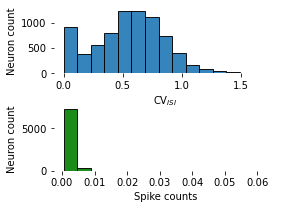

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(4, 3))
sp = M1G4.i
times = M1G4.t/ms
nNeurons = max(sp) + 1
nSpikes = len(sp)

spiketimes = {}
for n in range(nNeurons):
    ts = list(times[(np.where(sp == n))])
    #ts = [t for t in ts if t > 500 * ms]
    spiketimes[n] = ts
isi_stds = []
isi_cvs = []
for n in range(nNeurons):
    isi_std = np.std(np.diff(spiketimes[n]))
    isi_cv = np.std(np.diff(spiketimes[n])) / np.mean(np.diff(spiketimes[n]))
        #plt.scatter(n, np.std(np.diff(spiketimes[n])))
    isi_stds.append(isi_std)  
    isi_cvs.append(isi_cv)
        
meanFiringRates = []
for n in range(nNeurons):
    meanFiringRates.append(1/np.mean(np.diff(spiketimes[n])))
        
    

axs[0].hist(isi_cvs, bins=15, alpha=0.9, edgecolor='black');
axs[1].hist(meanFiringRates,bins=15, alpha=0.9, edgecolor='black',color="green");
    
for k in range(1):
    leg = axs[k].legend(loc=1)
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)
   
for k in range(2):
    axs[k].spines['right'].set_visible(False)
    axs[k].spines['top'].set_visible(False)
    axs[k].spines['bottom'].set_visible(False)
    axs[k].spines['left'].set_visible(False)
#axs[0].set_xticks([0, 0.5, 1.0])
#axs[0].set_yticks([0, 10, 20])

#axs[0].set_xlim(0, 1.6)
axs[0].set_xlabel("CV$_{ISI}$")
axs[1].set_xlabel("Spike counts")

axs[0].set_ylabel("Neuron count")
axs[1].set_ylabel("Neuron count")

plt.subplots_adjust(hspace=0.5)

### Draw distribution

1.0000000000000007e-08 1.1180339887219443e-05 0.5247965918467479 6.491887650492998e-06 0.6390968632923207 0.1490945045420307 4.613344479985466 0.40508183579432433


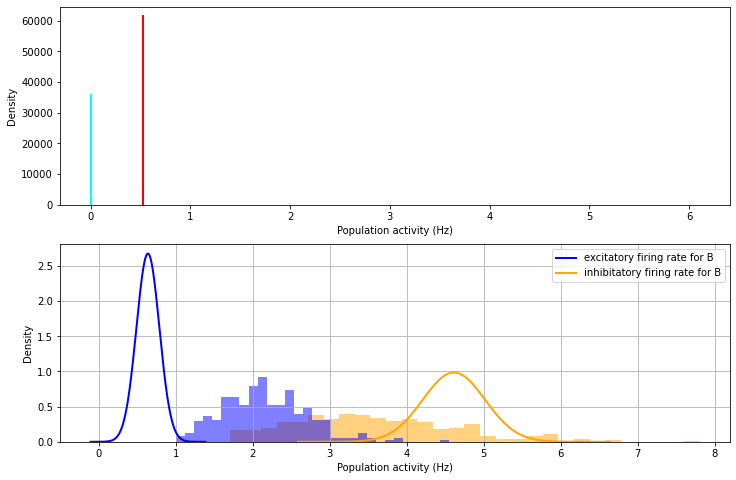

In [20]:
import scipy.stats
import cmath

def gaussian(x,mean,std):
    return 1/(np.sqrt(2*math.pi*std**2))*math.exp(-(x-mean)**2/(2*std**2))

fig, axs = plt.subplots(2, 1, figsize=(12, 8))

'''Remove transient'''

ST_popRateG1=popRateG1[int(len(popRateG1)/5)::] 
ST_popRateG2=popRateG2[int(len(popRateG2)/5)::]
ST_popRateG3=popRateG3[int(len(popRateG3)/5)::] 
ST_popRateG4=popRateG4[int(len(popRateG4)/5)::]

axs[0].hist(ST_popRateG1, color='red',density= True, bins=30, alpha=0.5)
axs[0].hist(ST_popRateG2, color='cyan',density=True, bins=30, alpha=0.5)
axs[1].hist(ST_popRateG3, color='orange',density= True, bins=30, alpha=0.5)
axs[1].hist(ST_popRateG4, color='blue',density=True, bins=30, alpha=0.5)


mean_RS1=final_state[0]
std_RS1=np.sqrt(final_state[4])

mean_RS2=final_state[1]
std_RS2=np.sqrt(final_state[9])

mean_FS1=final_state[2]
std_FS1=np.sqrt(final_state[12])

mean_FS2=final_state[3]
std_FS2=np.sqrt(final_state[19])


print(mean_RS1,std_RS1,mean_FS1,std_FS1,mean_RS2,std_RS2,mean_FS2,std_FS2)

x_min_RS1=mean_RS1-5*std_RS1 #x_min_RS=mean_RS-5*std_RS
x_max_RS1=mean_RS1+5*std_RS1

x_min_RS2=mean_RS2-5*std_RS2 #x_min_RS=mean_RS-5*std_RS
x_max_RS2=mean_RS2+5*std_RS2

x_min_FS1=mean_FS1-5*std_FS1
x_max_FS1=mean_FS1+5*std_FS1

x_min_FS2=mean_FS2-5*std_FS2
x_max_FS2=mean_FS2+5*std_FS2

x_RS1 = np.linspace(x_min_RS1, x_max_RS1, 1000)
x_FS1 = np.linspace(x_min_FS1, x_max_FS1, 1000)
x_RS2 = np.linspace(x_min_RS2, x_max_RS2, 1000)
x_FS2 = np.linspace(x_min_FS2, x_max_FS2, 1000)


Distrib_RS1=[]
Distrib_FS1=[]
Distrib_RS2=[]
Distrib_FS2=[]


for i in range(len(x_RS1)):
    Distrib_RS1.append(gaussian(x_RS1[i],mean_RS1,std_RS1))
    Distrib_RS2.append(gaussian(x_RS2[i],mean_RS2,std_RS2))
    Distrib_FS1.append(gaussian(x_FS1[i],mean_FS1,std_FS1))
    Distrib_FS2.append(gaussian(x_FS2[i],mean_FS2,std_FS2))


axs[0].plot(x_RS1,Distrib_RS1,color='cyan',lw=2,label='excitatory firing rate for A')
axs[1].plot(x_RS2,Distrib_RS2,color='blue',lw=2,label='excitatory firing rate for B')
axs[0].plot(x_FS1,Distrib_FS1,color='red',lw=2, label='inhibitatory firing rate for A')
axs[1].plot(x_FS2,Distrib_FS2,color='orange',lw=2, label='inhibitatory firing rate for B')
                             
axs[0].set_xlabel("Population activity (Hz)")
axs[0].set_ylabel("Density")
axs[1].set_xlabel("Population activity (Hz)")
axs[1].set_ylabel("Density")
plt.grid(True)
#plt.ylabel("Density")
plt.legend()
plt.show()

In [43]:
print(x_max_RS)

0.7664898782012017


In [41]:
x_transp=np.transpose(x_trace_RS)
TF_transp=np.transpose(TF_trace_RS)
ve1=x_transp[0]#[1000:] # remove first 10000 elements
ve2=x_transp[1]#[1000:]
vi1=x_transp[2]#[1000:]
vi2=x_transp[3]#[1000:]
#ce1i1=np.sqrt(x_transp[5])#[1000:]
#cii=np.sqrt(x_transp[5])#[1000:]
w1=x_transp[20]
w2=x_transp[21]
#cv_i=cee/ve
#cv_e=cii/vi
#print(cee[:1000],cii[:1000])

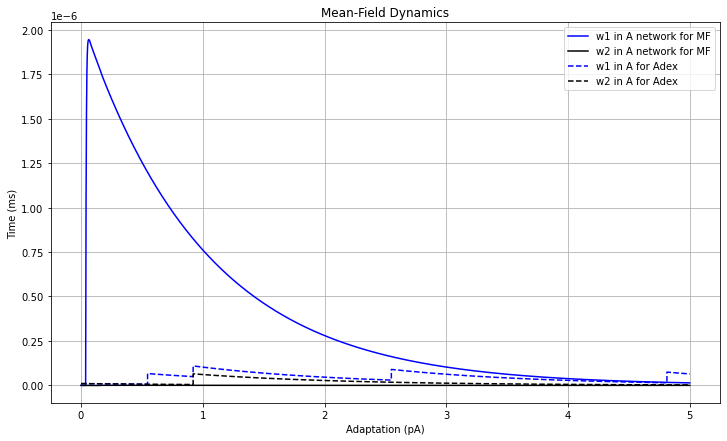

In [22]:
plt.figure(figsize=(12, 7))
#plt.plot(t_trace, ve, color="green", label="excitatory firing rate")
#plt.plot(t_trace, vi, color="red", label="inhibitory firing rate")
#plt.plot(TimBinned/1000,  popRateG2, color="green",ls="--", label="excitatory firing rate")
#plt.plot(TimBinned/1000, popRateG1, color="red",ls="--", label="inhibitory firing rate")
#plt.plot(t_trace, cee, color="blue", label="excitory cee")
#plt.plot(t_trace, cii, color="purple", label="inhibitory cii")
#plt.plot(t_trace, cei, color="yellow", label="cei")
#plt.plot(t_trace, cie, color="orange", label="cie")
plt.plot(t_trace,w1,color="blue",label="w1 in A network for MF")
plt.plot(t_trace,w2,color="black",label="w2 in A network for MF")
#for a in range(len(LVG1)):
    #plt.plot(Lt2G2/400,LwG2[a],color="blue",ls='--',label="w1 in A for Adex")
#for a in range(len(LVG3)):
    #plt.plot(Lt2G4/400,LwG4[a],color="black",ls='--',label="w2 in A for Adex")
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red", ls="--")
#plt.plot(t_trace,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Adaptation (pA)")
plt.grid(True)
plt.ylabel("Time (ms)")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(-20,20)
#plt.xlim(0,0.1)
plt.show()

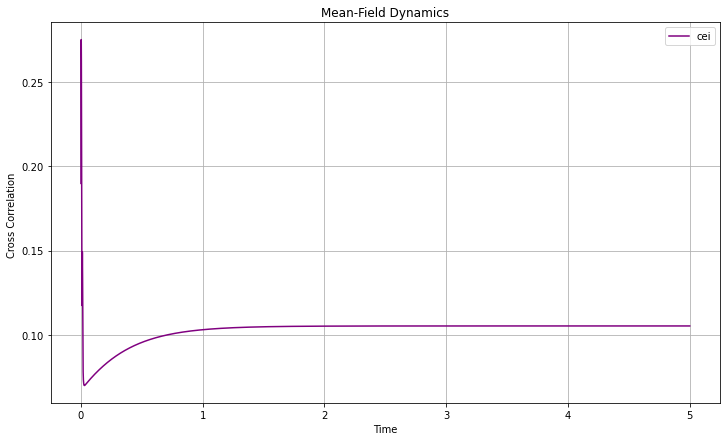

In [20]:
plt.figure(figsize=(12, 7))
#plt.plot(t_trace, ve, color="green", label="excitory firing rate")
#plt.plot(t_trace, vi, color="red", label="inhibitory firing rate")
#plt.plot(t_trace, cee, color="blue", label="excitory cee")
#plt.plot(t_trace, cii, color="purple", label="inhibitory cii")
plt.plot(t_trace, ce1i1, color="purple", label="ce1i1")
#plt.plot([-t_trace,t_trace], cie*1e-4, color="orange", label="cie")
#plt.plot(t_trace,w2*1e5,color="black",label="w")
#plt.plot(t_trace2, ve2, color="green", ls="--")
#plt.plot(t_trace2, vi2, color="red", ls="--")
#plt.plot(t_trace,test_input, color="black", linestyle=":", label="forcing")



plt.xlabel("Time")
plt.grid(True)
plt.ylabel("Cross Correlation ")
plt.legend()
plt.title("Mean-Field Dynamics")
#plt.ylim(0,6000)
#plt.xlim(0,0.1)
plt.show()